# Assignment 4
Question for EOF analysis

Download the SST temperature for the period from 1982-2020 from the reanalysis data. Normalize the data using the normalization/standardization. 
Using the normalized SST data find the EOF 1 and EOF 2 which explains the maximum variabilities along with the PCs.

In [1]:
# Importing required libraries

from eofs.standard import Eof
from mpl_toolkits.basemap import Basemap
import numpy as np
from scipy import signal
import numpy.polynomial.polynomial as poly
from netCDF4 import Dataset
import matplotlib.pyplot as plt

In [2]:
## Reading SST data (monthly mean sea surface temperature)

file_path = 'sst.mnmean.nc'
ncin = Dataset(file_path,'r')
print(ncin.variables.keys())

sst = ncin.variables['sst'][1:457,:,:]  #1982 to 2020
lat = ncin.variables['lat'][:]
lon = ncin.variables['lon'][:]

nt,nlat,nlon = sst.shape
print(sst.shape)

dict_keys(['lat', 'lon', 'sst', 'time', 'time_bnds'])
(456, 180, 360)


In [3]:
# Reading the mask data (1 is ocean and 0 is land), as we are taking only sea surface temperature
infile = 'lsmask.nc'
lmset = Dataset(infile,'r')

print(lmset.variables.keys())

print(lmset.dimensions)

lsmask = lmset.variables['mask'][0,:,:]
lsmask

dict_keys(['lat', 'lon', 'time', 'mask'])
{'lon': <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 360, 'lat': <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 180, 'time': <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 1}


masked_array(
  data=[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

In [4]:
print(lsmask.shape)

(180, 360)


In [5]:
num_repeats = nt
lsm = np.stack([lsmask]*num_repeats,axis=-1).transpose(2,0,1)
lsm.shape

(456, 180, 360)

In [6]:
lsm

masked_array(
  data=[[[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0.,

In [7]:
# Rearranging the data for seasonal removal

sst = sst.reshape(nt,nlat*nlon,order ='F') # F means column by bolumn, C means row by row
sst_detrend = signal.detrend(sst,axis=0, type='linear', bp=0) # axis=0 means applied along the rows
sst_detrend = sst_detrend.reshape((12,nt//12,nlat,nlon), order = 'F').transpose((1,0,2,3))
print(sst_detrend.shape)

(38, 12, 180, 360)


In [8]:
# Caclculating seasonal cycle

sst_season = np.mean(sst_detrend, axis=0) 

In [9]:
# Removing seasonal cycle

sst_diff = sst_detrend - sst_season
sst_diff = sst_diff.transpose((1,0,2,3)).reshape((nt,nlat,nlon),order="F")
sst_diff.shape

(456, 180, 360)

In [10]:
sst_diff = sst_diff*lsm

In [11]:
# Craeting an EOF solver to do the EOF analysis

wgts = np.cos(np.deg2rad(lat))
wgts = wgts.reshape(len(wgts),1)
solver = Eof(sst_diff,weights=wgts)

In [12]:
solver2 = Eof(sst_season,weights=wgts) 

In [13]:
# Retrieving the leading Eofs

eof1 = solver.eofs(neofs=2) # Gives out 2 EOFs
pc1 = solver.pcs(npcs=2, pcscaling=0) # 2 PCs with no scaling
varfrac = solver.varianceFraction() # Calculates the fraction of variance expalined by each EOF
lambdas = solver.eigenvalues() # Retrieves the eigen values obtained during the EOF analysis process

In [14]:
pc1_1982_2020 = pc1[:,0]
pc2_1982_2020 = pc1[:,1]

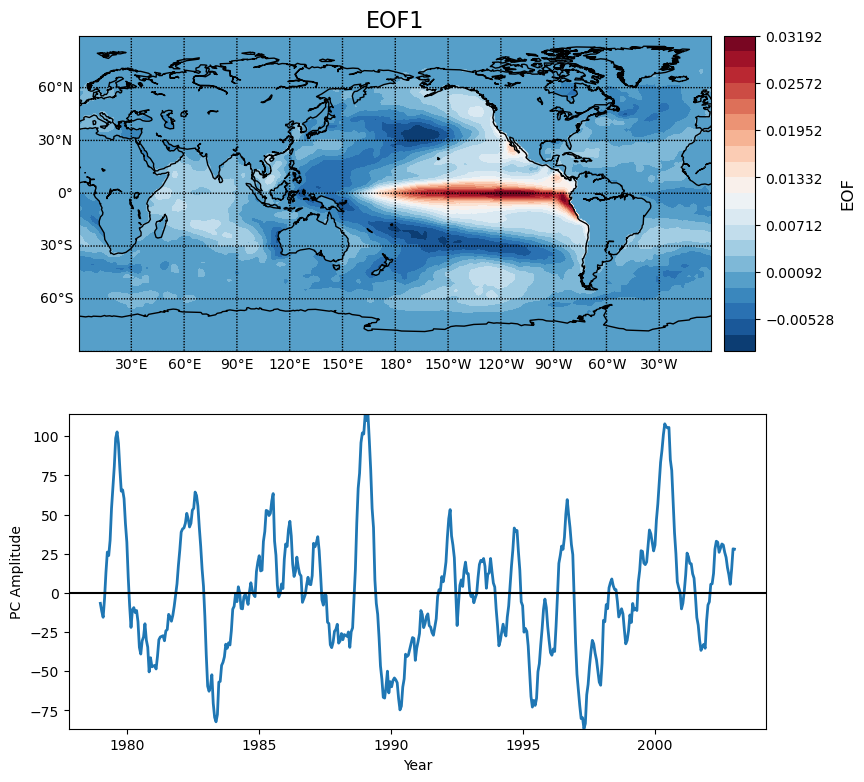

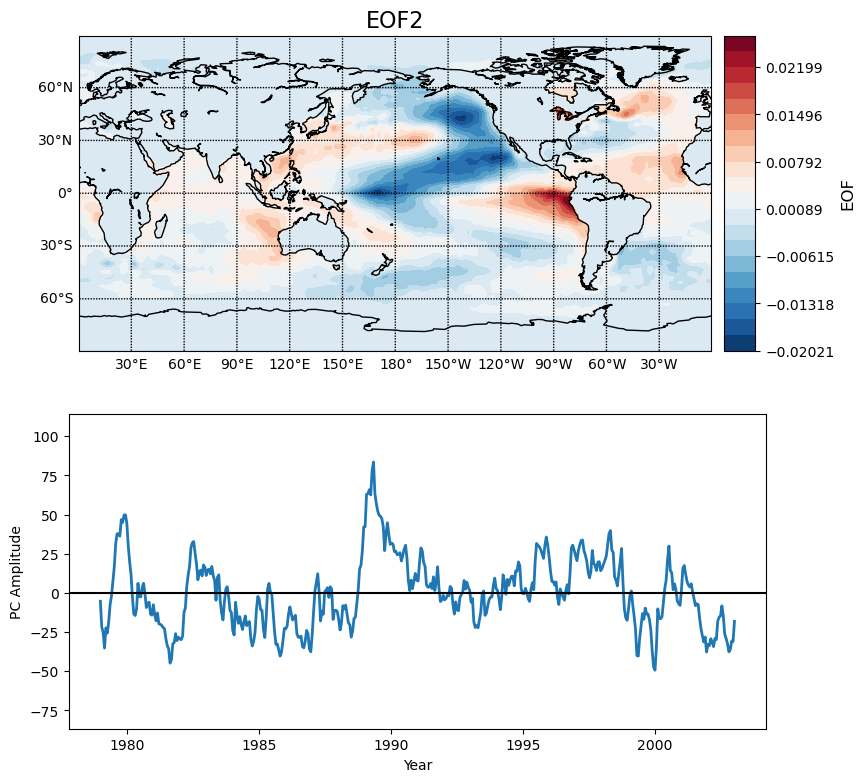

In [15]:
# Plot EOFs and PCs

parallels = np.arange(-90,90,30)
meridians = np.arange(-180,180,30)

for i in range(0,2):
    fig = plt.figure(figsize=(9,9))
    plt.subplot(211)
    
    m = Basemap(projection='cyl', llcrnrlon=min(lon), llcrnrlat=min(lat), urcrnrlon=max(lon), urcrnrlat=max(lat))
    x,y = m(*np.meshgrid(lon,lat))
    clevs = np.linspace(np.min(eof1[i,:,:].squeeze()), np.max(eof1[i,:,:].squeeze()),21)
    cs = m.contourf(x,y,eof1[i,:,:].squeeze(),clevs, cmap=plt.cm.RdBu_r)
    m.drawcoastlines()
    m.drawparallels(parallels, labels=[1,0,0,0])
    m.drawmeridians(meridians, labels=[1,0,0,1])
    
    cb = m.colorbar(cs,'right', size='5%', pad='2%')
    cb.set_label('EOF',fontsize=12)
    plt.title('EOF' + str(i+1), fontsize=16)
    
    plt.subplot(212)
    days = np.linspace(1979,2003,nt)
    plt.plot(days,pc1[:,i],linewidth=2)
    plt.axhline(0,color="k")
    plt.xlabel('Year')
    plt.ylabel('PC Amplitude')
    plt.ylim(np.min(pc1.squeeze()), np.max(pc1.squeeze()))

In [16]:
pc1[0]

array([-6.647585, -5.307267], dtype=float32)

(4.468057503910256e-16, 0.1996335631608963)

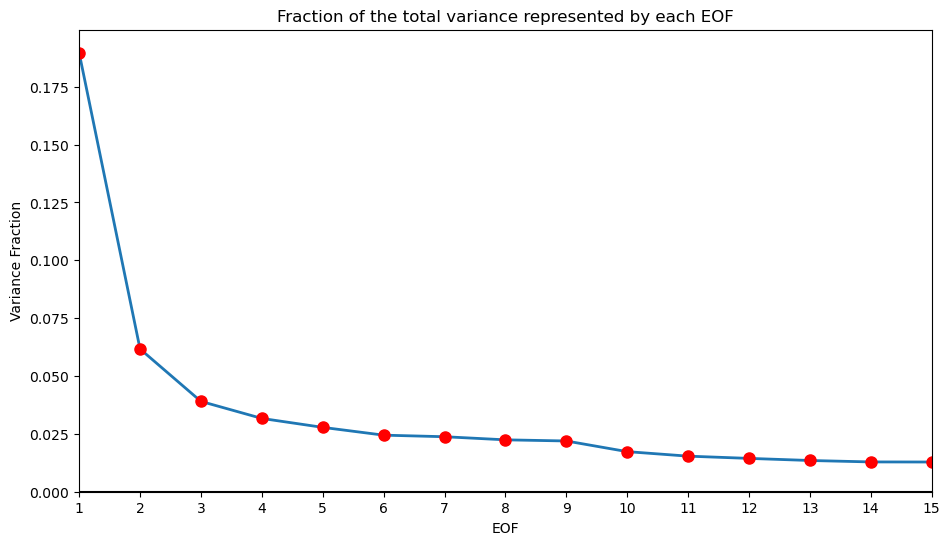

In [17]:
# Checking the variances explained by leading EOFs

plt.figure(figsize=(11,6))
eof_num = range(1,16)
plt.plot(eof_num, varfrac[0:15], linewidth=2)
plt.plot(eof_num, varfrac[0:15], linestyle='None', marker='o', color='r', markersize=8)
plt.axhline(0,color="k")
plt.xticks(range(1,16))
plt.title('Fraction of the total variance represented by each EOF')
plt.xlabel('EOF')
plt.ylabel('Variance Fraction')
plt.xlim(1,15)
plt.ylim(np.min(varfrac),np.max(varfrac)+0.01)

10/04/24

1. Estimate the correlation between the PC1 (obtained from EOF of SST) and monthly precipitation and PC2 and monthly precipitation for the Indian sub continent region

In [18]:
import pandas as pd
df_rain = pd.read_csv("data_monthly.csv")

In [33]:
df_rain

,Unnamed: 0,latitude,longitude,1901-01-01 00:00:00,1901-02-01 00:00:00,1901-03-01 00:00:00,1901-04-01 00:00:00,1901-05-01 00:00:00,1901-06-01 00:00:00,1901-07-01 00:00:00,...,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00,2021-06-01 00:00:00,2021-07-01 00:00:00,2021-08-01 00:00:00,2021-09-01 00:00:00,2021-10-01 00:00:00,2021-11-01 00:00:00,2021-12-01 00:00:00
0,0,37.25,74.75,6.400000,2.000000,3.800000,7.100000,22.1,20.500000,0.0,...,106.085446,74.301959,15.767155,16.544888,61.152262,13.861914,100.260022,65.235641,2.422658,7.549552
1,1,37.25,75.00,6.400000,2.000000,3.800000,7.100000,22.1,20.500000,0.0,...,119.602172,94.340551,19.446078,15.098889,64.965150,16.329034,80.854628,68.088913,2.851044,9.096201
2,2,37.25,75.25,6.400000,2.000000,3.800000,7.100000,22.1,20.500000,0.0,...,127.293214,110.876931,22.451105,13.472498,67.552252,17.953028,63.793888,70.642146,3.149002,10.259153
3,3,37.25,75.50,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,37.00,73.75,6.400000,2.000000,3.800000,7.100000,22.1,20.500000,0.0,...,33.109350,16.452705,3.768727,18.197946,43.516418,3.678716,162.460879,61.024402,0.685788,2.051089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4959,4959,8.50,78.25,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4960,4960,8.25,77.25,80.600000,45.300000,50.100000,137.600001,31.5,339.399997,18.9,...,20.173624,72.694346,457.522231,88.978337,119.967896,35.475643,121.626730,348.116645,492.742531,111.378290
4961,4961,8.25,77.50,20.599999,45.600001,97.799999,64.899999,4.5,137.100000,14.0,...,47.515064,30.583617,207.705288,5.231406,45.696839,12.324028,61.796999,239.211002,347.764789,51.801950
4962,4962,8.25,77.75,58.500000,36.300000,98.700002,53.499999,4.4,64.599999,4.9,...,35.560469,24.103243,111.278132,17.455790,23.598290,11.358191,33.992296,215.157636,401.586532,46.194313


In [37]:
df_1982_2019 = df_rain.loc[:,"1982-01-01 00:00:00":"2019-12-01 00:00:00"]
df_1982_2019.head()

,1982-01-01 00:00:00,1982-02-01 00:00:00,1982-03-01 00:00:00,1982-04-01 00:00:00,1982-05-01 00:00:00,1982-06-01 00:00:00,1982-07-01 00:00:00,1982-08-01 00:00:00,1982-09-01 00:00:00,1982-10-01 00:00:00,...,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00,2019-09-01 00:00:00,2019-10-01 00:00:00,2019-11-01 00:00:00,2019-12-01 00:00:00
0,8.0,103.400000,117.099999,79.800000,68.0,11.5,46.200000,102.599998,25.499999,54.900000,...,58.002953,47.415650,64.664836,57.168018,91.816602,251.309275,40.531922,37.760257,147.490840,16.951236
1,11.8,123.700001,138.300000,91.399999,78.1,13.3,41.400001,108.200000,29.600000,64.300001,...,66.156309,53.814180,80.564448,65.640677,82.286190,226.672529,32.705274,38.969054,148.720162,19.816770
2,17.6,141.900001,153.999999,97.400001,84.8,14.3,37.100000,109.699999,32.700000,71.400000,...,70.751708,57.585308,93.230514,71.899105,73.040465,201.339494,25.574603,38.994026,145.737405,21.940876
3,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1.2,32.100000,31.200000,25.700000,21.9,3.4,61.800001,67.999999,8.100000,17.300000,...,17.495008,14.594784,15.280491,26.328943,115.390924,310.507111,64.983422,32.017124,102.052332,4.984307


In [47]:
df_1982_2019.fillna(0,inplace=True)

In [48]:
(df_1982_2019.loc[0].values).shape

(456,)

In [49]:
pc1_1982_2020 = pc1[:,0]
pc2_1982_2020 = pc1[:,1]

In [50]:
pc1_1982_2020.shape

(456,)

In [51]:
import numpy as np
array1 = pc1_1982_2020
cor = []
for i in range(4964):
    array2 = df_1982_2019.loc[i].values
    
    # Find the correlation coefficient
    correlation_coefficient = np.corrcoef(array1, array2)[0, 1]
    cor.append(correlation_coefficient)

In [63]:
len(cor)

4964

In [59]:
import seaborn as sns

In [64]:
df_rain['Correlation Values'] = cor

In [70]:
df_rain

,Unnamed: 0,latitude,longitude,1901-01-01 00:00:00,1901-02-01 00:00:00,1901-03-01 00:00:00,1901-04-01 00:00:00,1901-05-01 00:00:00,1901-06-01 00:00:00,1901-07-01 00:00:00,...,2021-04-01 00:00:00,2021-05-01 00:00:00,2021-06-01 00:00:00,2021-07-01 00:00:00,2021-08-01 00:00:00,2021-09-01 00:00:00,2021-10-01 00:00:00,2021-11-01 00:00:00,2021-12-01 00:00:00,Correlation Values
0,0,37.25,74.75,6.400000,2.000000,3.800000,7.100000,22.1,20.500000,0.0,...,74.301959,15.767155,16.544888,61.152262,13.861914,100.260022,65.235641,2.422658,7.549552,0.057998
1,1,37.25,75.00,6.400000,2.000000,3.800000,7.100000,22.1,20.500000,0.0,...,94.340551,19.446078,15.098889,64.965150,16.329034,80.854628,68.088913,2.851044,9.096201,0.077259
2,2,37.25,75.25,6.400000,2.000000,3.800000,7.100000,22.1,20.500000,0.0,...,110.876931,22.451105,13.472498,67.552252,17.953028,63.793888,70.642146,3.149002,10.259153,0.092063
3,3,37.25,75.50,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
4,4,37.00,73.75,6.400000,2.000000,3.800000,7.100000,22.1,20.500000,0.0,...,16.452705,3.768727,18.197946,43.516418,3.678716,162.460879,61.024402,0.685788,2.051089,-0.003809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4959,4959,8.50,78.25,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
4960,4960,8.25,77.25,80.600000,45.300000,50.100000,137.600001,31.5,339.399997,18.9,...,72.694346,457.522231,88.978337,119.967896,35.475643,121.626730,348.116645,492.742531,111.378290,-0.034123
4961,4961,8.25,77.50,20.599999,45.600001,97.799999,64.899999,4.5,137.100000,14.0,...,30.583617,207.705288,5.231406,45.696839,12.324028,61.796999,239.211002,347.764789,51.801950,-0.011863
4962,4962,8.25,77.75,58.500000,36.300000,98.700002,53.499999,4.4,64.599999,4.9,...,24.103243,111.278132,17.455790,23.598290,11.358191,33.992296,215.157636,401.586532,46.194313,0.009891


In [73]:
corr_matrix= df_rain.pivot_table(values='Correlation Values', index='latitude', columns='longitude' )

In [74]:
corr_matrix.sort_values(by= 'latitude', ascending= False)

longitude,68.25,68.50,68.75,69.00,69.25,69.50,69.75,70.00,70.25,70.50,...,95.00,95.25,95.50,95.75,96.00,96.25,96.50,96.75,97.00,97.25
latitude,,,,,,,,,,,,,,,,,,,,,
37.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Correlation between PC1 of SST and Monthly Rainfall')

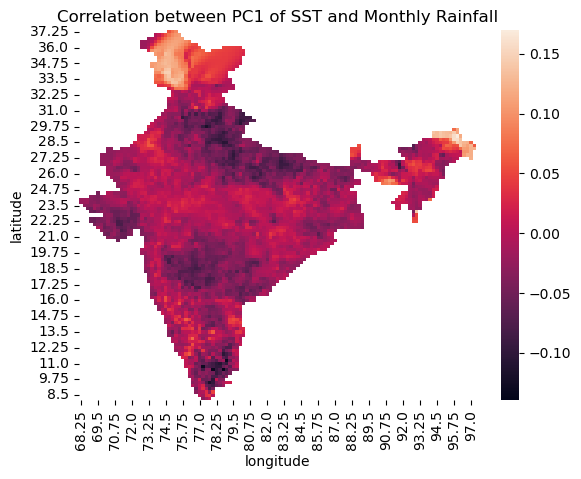

In [75]:
sns.heatmap(corr_matrix.sort_values(by= 'latitude', ascending= False))
plt.title('Correlation between PC1 of SST and Monthly Rainfall')

2. Consider the monthly precipitation for the Indian subcontinent and perform the EOF analysis for this data 

2.1 Estimate the correalation between PC1(precipitation) vs PC1(SST)

2.2 Estimate the correalation between PC2(precipitation) vs PC2(SST) 

3. Do the wavelet analysis for the PCs and 